# Deconvolution
Evaluate the performance of deconvolution for age prediction.

In [1]:
from utils.variation import meanexp, group_counts, sum_squares, var_comp
from utils.misc import extract_number
import pandas as pd
import numpy as np
from scipy.stats import rankdata
import os
import matplotlib.pyplot as plt
from utils.viz import single_line_plot, single_scatter_plot, multi_scatter_plot

## Load Data

In [2]:
gene_expressions = pd.read_csv("data/train_data.csv", index_col=0)
gene_expressions_mat = gene_expressions.to_numpy()
genenames = np.array(gene_expressions.index.tolist())
samples = gene_expressions.columns.tolist()

# extract ages
ages = np.array([extract_number(timestring) for timestring in samples])
unique_ages=np.unique(ages)


# retain genes that are present in all samples
prevalence = np.mean(gene_expressions_mat > 0, axis=1)
subset_gene_id = np.where(prevalence == 1)[0]
subset_genenames = genenames[subset_gene_id]
gene_expressions = gene_expressions.loc[subset_genenames, :]
gene_expressions_mat = gene_expressions_mat[subset_gene_id, :]

# get log expressions
log_gene_expressions = np.log(gene_expressions)
log_gene_expressions_mat = np.log(gene_expressions_mat)

# transpose count tables to samples by genes
gene_expressions = gene_expressions.T
gene_expressions_mat = gene_expressions_mat.T
log_gene_expressions = log_gene_expressions.T
log_gene_expressions_mat = log_gene_expressions_mat.T

# get rankings of samples for each gene expression
gene_expressions_rank = log_gene_expressions.rank()


# Visualizing Genes
Plot the genes that have the most distinct expressions between samples of different ages.

In [6]:
def plot_top_genes(expressions_df, ages, age_min, age_max, type="raw", num_genes=50):

    if type not in ["raw", "log", "rank"]:
        raise ValueError("Argument must be one of 'raw', 'log', 'rank'")

    if type == "raw":
        input_df = expressions_df
    elif type == "log":
        input_df = np.log(expressions_df)
    else:
        input_df = expressions_df.rank()

    mask = np.logical_and(ages >= age_min, ages <= age_max)
    input_df = input_df.loc[mask, :]
    ages = ages[mask]
    unique_ages = np.unique(ages)
    age_rank = rankdata(ages, method='min').astype(int)
    unique_ranks = np.unique(age_rank)

    varcomp_sorted = var_comp(geneexp_df=input_df, groups=ages)
    varcomp_sorted = varcomp_sorted.sort_values(by='R2', ascending=False)
    sorted_genes = varcomp_sorted.index.tolist()

    for id in range(num_genes):

        genename = sorted_genes[id]
        values = input_df.loc[:, genename].to_numpy()
        values = values.reshape(1, -1)
        if type=="raw":
            fig = single_scatter_plot(ymat=values, xmat=age_rank.reshape(1, -1),
                                    xticks=unique_ranks, xticknames=unique_ages.astype(str),
                                    xname="Age (Month)", yname="Raw Expression", title=genename)
        elif type == "log":
            fig = single_scatter_plot(ymat=values, xmat=age_rank.reshape(1, -1),
                                    xticks=unique_ranks, xticknames=unique_ages.astype(str),
                                    xname="Age (Month)", yname="Log Expression", title=genename)
        else:
            fig = single_scatter_plot(ymat=values, xmat=age_rank.reshape(1, -1),
                                    xticks=unique_ranks, xticknames=unique_ages.astype(str),
                                    xname="Age (Month)", yname="Rank of Expression", title=genename)
        filename = f"{id}_{genename}_{age_min}_{age_max}_{type}.png"
        fig.savefig(os.path.join("gene_plots", type, f"age_{age_min}_{age_max}", filename), bbox_inches="tight")
        plt.close(fig)


In [61]:
plot_top_genes(expressions_df=gene_expressions, ages=ages, age_min=2, age_max=42, type="raw")
plot_top_genes(expressions_df=gene_expressions, ages=ages, age_min=2, age_max=42, type="log")
plot_top_genes(expressions_df=gene_expressions, ages=ages, age_min=2, age_max=42, type="rank")

In [62]:
plot_top_genes(expressions_df=gene_expressions, ages=ages, age_min=4, age_max=23, type="raw")
plot_top_genes(expressions_df=gene_expressions, ages=ages, age_min=4, age_max=23, type="log")
plot_top_genes(expressions_df=gene_expressions, ages=ages, age_min=4, age_max=23, type="rank")

In [63]:
plot_top_genes(expressions_df=gene_expressions, ages=ages, age_min=4, age_max=42, type="raw")
plot_top_genes(expressions_df=gene_expressions, ages=ages, age_min=4, age_max=42, type="log")
plot_top_genes(expressions_df=gene_expressions, ages=ages, age_min=4, age_max=42, type="rank")

In [64]:
plot_top_genes(expressions_df=gene_expressions, ages=ages, age_min=6, age_max=18, type="raw")
plot_top_genes(expressions_df=gene_expressions, ages=ages, age_min=6, age_max=18, type="log")
plot_top_genes(expressions_df=gene_expressions, ages=ages, age_min=6, age_max=18, type="rank")

## Deconvolution

I attempted deconvolution with different:
* Input: raw gene expression, log gene expression or ranks of gene expression
* Number of genes included
* Weight of the genes

In [68]:
from utils.deconvolution import loo_predict, mae

In [69]:
def mae_tune(input_expression, labels, label_min=2, label_max=50,
             log=False, rank=False, numgenes=np.array([50, 100, 200, 400, 600, 800, 1000, 2000, 5000, 10000, 16000])):

    expressions = input_expression.copy()
    targets = labels.copy()
    mask = np.logical_and(targets >= label_min, targets <= label_max)
    expressions = expressions.loc[mask, :]
    targets = targets[mask]

    if log:
        expressions = np.log(expressions)
    if rank:
        expressions = expressions.rank()

    # calculate sorted R^2
    varcomp_sorted = var_comp(geneexp_df=expressions, groups=targets)
    varcomp_sorted = varcomp_sorted.sort_values(by='R2', ascending=False)
    sorted_genes = varcomp_sorted.index.tolist()

    results_df = pd.DataFrame({"NumGene": numgenes,
                            "MAE_None": 0,
                            "MAE_R2": 0})

    best_mae = 20
    best_predictions = np.zeros_like(targets)

    for j in range(len(results_df)):
        num_genes = results_df["NumGene"][j]
        selected_genes = sorted_genes[0:num_genes]
        # weighed by R square
        output_R2 = loo_predict(expression_df=expressions.loc[:, selected_genes],
                                labels=targets, weighted="R2", normalize=True)
        mae_R2 = mae(output_R2[0]["Truth"], output_R2[0]["Predicted"], type="mean")
        if mae_R2 < best_mae:
            best_mae = mae_R2
            best_predictions = output_R2[0]["Predicted"]
        # no weights
        output_None = loo_predict(expression_df=expressions.loc[:, selected_genes],
                                labels=targets, weighted="None", normalize=True)
        mae_None = mae(output_None[0]["Truth"], output_None[0]["Predicted"], type="mean")
        if mae_None < best_mae:
            best_mae = mae_None
            best_predictions = output_None[0]["Predicted"]

        results_df["MAE_R2"][j] = mae_R2
        results_df["MAE_None"][j] = mae_None

    prediction_df = pd.DataFrame({"Truth": targets,
                                  "Predicted": best_predictions})

    return results_df, prediction_df


In [70]:
def aggregate_performance_report(expressions, ages, min_age=2, max_age=42):

    result_raw, prediction_raw = mae_tune(input_expression=expressions, labels=ages, label_min=min_age, label_max=max_age,
                           log=False, rank=False)

    result_log, prediction_log = mae_tune(input_expression=expressions, labels=ages, label_min=min_age, label_max=max_age,
                           log=True, rank=False)

    result_rank, prediction_rank = mae_tune(input_expression=expressions, labels=ages, label_min=min_age, label_max=max_age,
                           log=True, rank=True)

    maes = np.stack((result_raw["MAE_None"].to_numpy(),
                 result_raw["MAE_R2"].to_numpy(),
                 result_log["MAE_None"].to_numpy(),
                 result_log["MAE_R2"].to_numpy(),
                 result_rank["MAE_None"].to_numpy(),
                 result_rank["MAE_R2"].to_numpy()))
    truth = prediction_raw["Truth"].to_numpy()
    predictions = np.stack((prediction_raw["Predicted"].to_numpy(),
                            prediction_log["Predicted"].to_numpy(),
                            prediction_rank["Predicted"].to_numpy()))

    performance_title = f"{min_age}-{max_age} Months old"

    performance_plot = single_line_plot(ymat=maes, xticks=np.arange(len(result_raw)),
                                 xticknames=result_raw["NumGene"].to_numpy().astype(str),
                                 colors=np.repeat(["#344885", "#db382c", "#2f7028"], 2),
                                 linetypes=np.tile(['-o', '--o'], 3),
                                 xname="Number of Genes", yname="Mean Absolute Error",
                                 legend_labels=["Raw_equal", "Raw_R2", "Log_equal", "Log_R2", "Ranks_equal", "Ranks_R2"],
                                 title=performance_title)
    performance_plot.savefig(f"deconvolution/plots/MAEs/MAE_{min_age}_{max_age}.png", bbox_inches="tight")

    prediction_plot = multi_scatter_plot(ymat=predictions, xticks=truth, xticknames=truth.astype(str),
                                         xname="True Age (Month)", yname="Predicted Age (Month)",
                                         titles=["Raw expressions", "Log expressions", "Rank"],
                                         size=(15, 4), diag_line=True)
    prediction_plot.savefig(f"deconvolution/plots/scatterplots/prediction_{min_age}_{max_age}.png", bbox_inches="tight")



/tmp/ipykernel_82532/817047044.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_df["MAE_None"][j] = mae_None
/tmp/ipykernel_82532/817047044.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_df["MAE_None"][j] = mae_None
/tmp/ipykernel_82532/817047044.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_df["MAE_None"][j] = mae_None


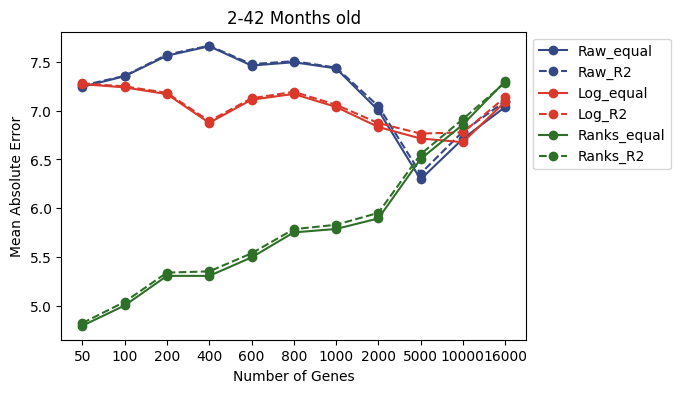

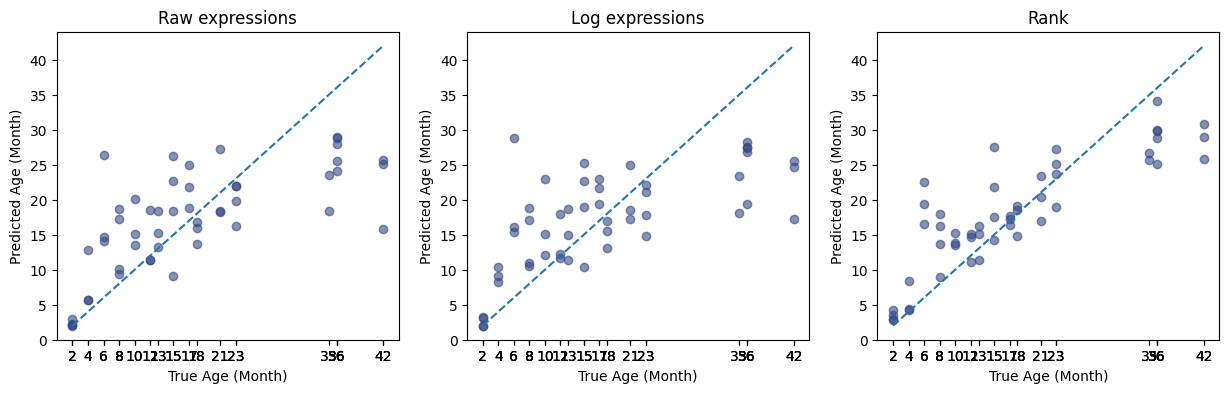

In [71]:
aggregate_performance_report(expressions=gene_expressions, ages=ages, min_age=2, max_age=42)

/tmp/ipykernel_82532/817047044.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_df["MAE_None"][j] = mae_None
/tmp/ipykernel_82532/817047044.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_df["MAE_None"][j] = mae_None
/tmp/ipykernel_82532/817047044.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_df["MAE_None"][j] = mae_None


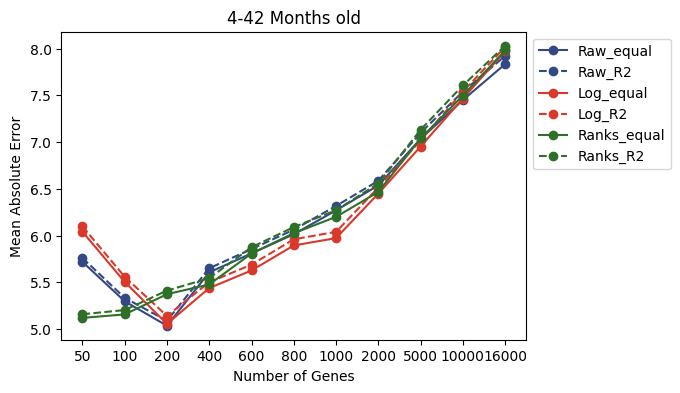

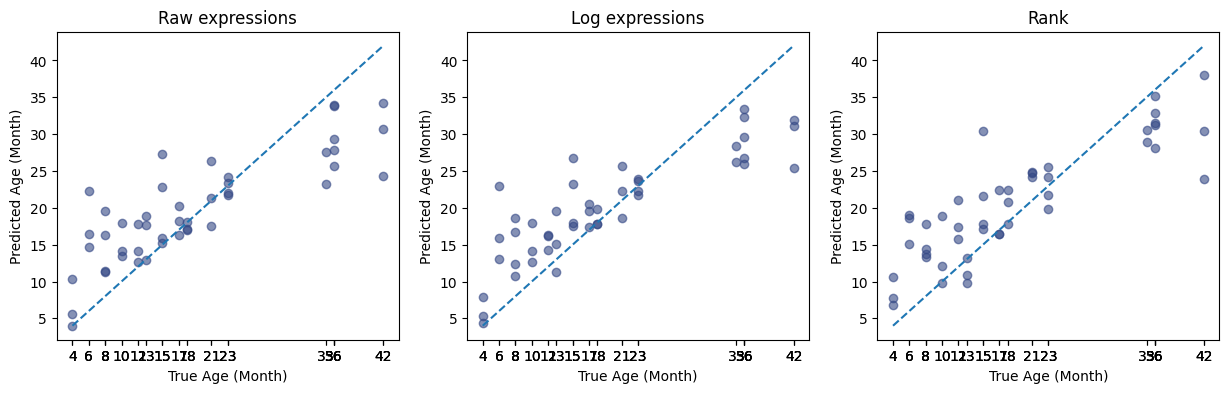

In [72]:
aggregate_performance_report(expressions=gene_expressions, ages=ages, min_age=4, max_age=42)

/tmp/ipykernel_82532/817047044.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_df["MAE_None"][j] = mae_None
/tmp/ipykernel_82532/817047044.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_df["MAE_None"][j] = mae_None
/tmp/ipykernel_82532/817047044.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_df["MAE_None"][j] = mae_None


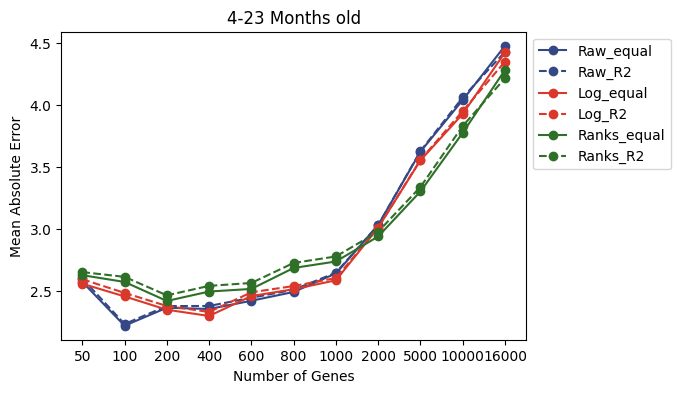

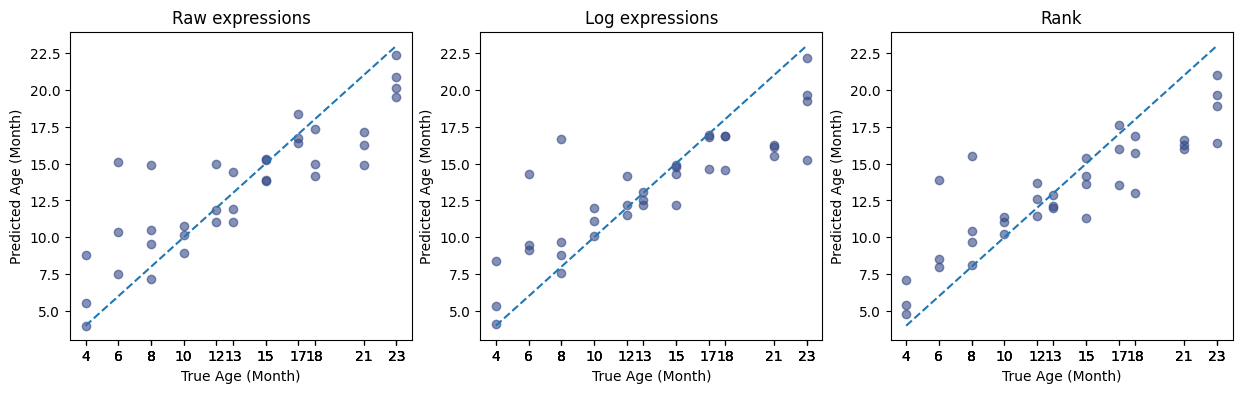

In [73]:
aggregate_performance_report(expressions=gene_expressions, ages=ages, min_age=4, max_age=23)

/tmp/ipykernel_82532/817047044.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_df["MAE_None"][j] = mae_None
/tmp/ipykernel_82532/817047044.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_df["MAE_None"][j] = mae_None
/tmp/ipykernel_82532/817047044.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_df["MAE_None"][j] = mae_None


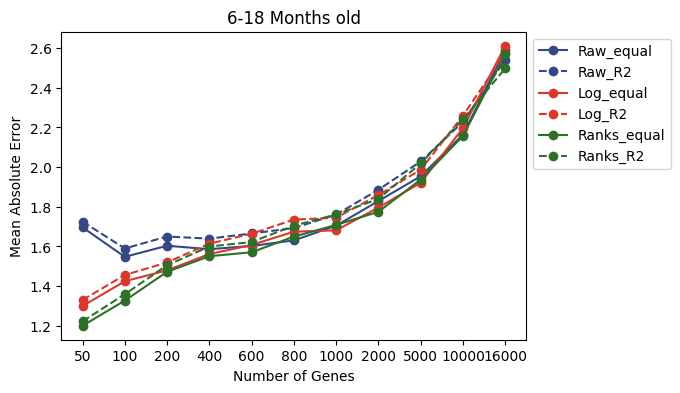

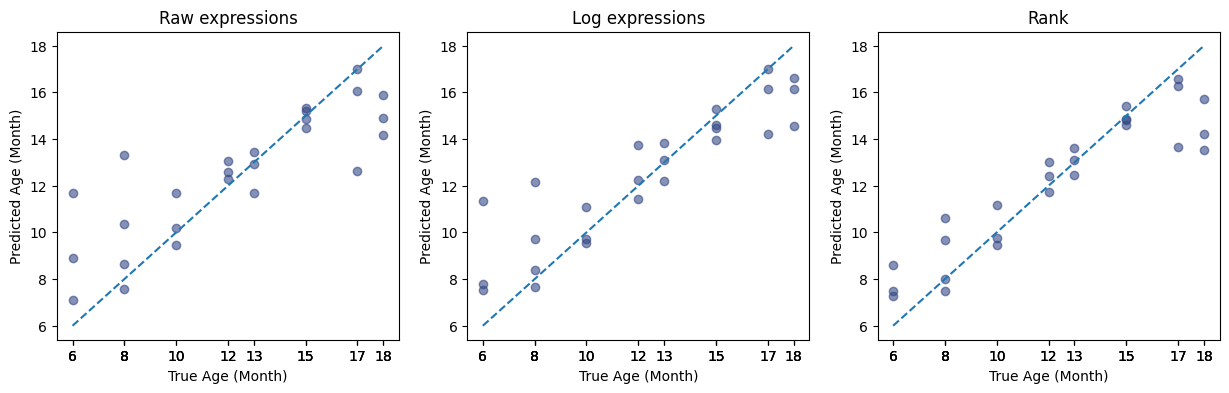

In [74]:
aggregate_performance_report(expressions=gene_expressions, ages=ages, min_age=6, max_age=18)